In [1]:
from bs4 import BeautifulSoup 
import requests
import numpy as np
import pandas as pd
import math

## STARTING FOR ASSIGNMENT FOR QUESTION 3

### STEP 1 - EXplore and cluster neighborhoods in Toronto: In this case, I am going to work with Borough that contains the word Toronto

In [23]:
toronto_data = post_geo[post_geo['Borough'].str.contains("Toronto")].reset_index(drop=True)
toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes

In [ ]:
from geopy.geocoders import Nominatim

import folium

In [ ]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

In [36]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

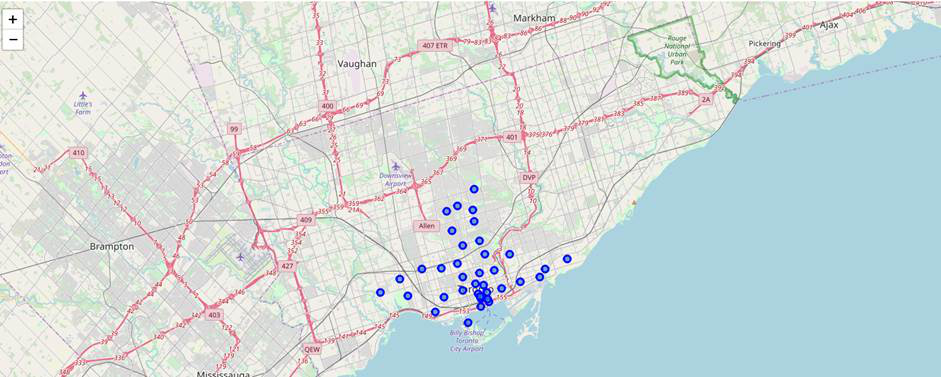

In [1]:
from IPython.display import Image
Image (filename='C:/Users/sudha27/Desktop/img/image003.png')

### STEP 2 - Access Foursquare credentials

In [37]:
CLIENT_ID = '02XI22LSV2ONB4TDCQKNMUXPECHUXN0BHAFDKXUFRLPQSY1Q' # your Foursquare ID
CLIENT_SECRET = 'KZFNH24O4EIKJIN35YNZW5CXKMBSCLGIPI2KXQXF2Y2TEQGG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 02XI22LSV2ONB4TDCQKNMUXPECHUXN0BHAFDKXUFRLPQSY1Q
CLIENT_SECRET:KZFNH24O4EIKJIN35YNZW5CXKMBSCLGIPI2KXQXF2Y2TEQGG


In [39]:
toronto_data.loc[0, 'Neighbourhood']

'Hillcrest Village'

In [40]:
neighbourhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighbourhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Hillcrest Village are 43.8037622, -79.3634517.


In [42]:
LIMIT = 100
radius = 500

In [44]:
url ='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url # display url

'https://api.foursquare.com/v2/venues/explore?&client_id=02XI22LSV2ONB4TDCQKNMUXPECHUXN0BHAFDKXUFRLPQSY1Q&client_secret=KZFNH24O4EIKJIN35YNZW5CXKMBSCLGIPI2KXQXF2Y2TEQGG&v=20180605&ll=43.8037622,-79.3634517&radius=500&limit=100'

In [45]:
results = requests.get(url).json()

In [46]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [48]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [49]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Eagle's Nest Golf Club,Golf Course,43.805455,-79.364186
1,AY Jackson Pool,Pool,43.804515,-79.366138
2,Villa Madina,Mediterranean Restaurant,43.801685,-79.363938
3,Duncan Creek Park,Dog Run,43.805539,-79.360695
4,A.Y. Jackson Secondary School Track,Athletics & Sports,43.805068,-79.366677


In [50]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


### STEP 3 - Explore and cluster neighbourhoods in Toronto

In [55]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [56]:
# type your answer here
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [57]:
print(toronto_venues.shape)
toronto_venues.head()

(1702, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
2,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
3,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [58]:
toronto_venues.groupby('Neighbourhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",20,20,20,20,20,20
Business reply mail Processing Centre969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",97,97,97,97,97,97
Christie,15,15,15,15,15,15


In [59]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### STEP 4 - Analyze each neighbourhood

In [60]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
toronto_onehot.shape

(1702, 236)

In [62]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.010000,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.01,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
3,Business reply mail Processing Centre969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,...,0.011765,0.000000,0.011765,0.000000,0.00,0.011765,0.000000,0.000000,0.00,0.011765
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.051546,0.000000,0.000000,0.051546,0.00,0.010309,0.000000,0.000000,0.00,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000
9,Church and Wellesley,0.012195,0.012195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,...,0.000000,0.012195,0.000000,0.012195,0.00,0.000000,0.012195,0.012195,0.00,0.012195


In [63]:
toronto_grouped.shape

(38, 236)

In [64]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2    Restaurant  0.05
3        Bakery  0.04
4   Cheese Shop  0.04


----Brockton, Exhibition Place, Parkdale Village----
                   venue  freq
0            Coffee Shop  0.15
1         Breakfast Spot  0.10
2                   Café  0.10
3  Performing Arts Venue  0.05
4                    Bar  0.05


----Business reply mail Processing Centre969 Eastern----
                venue  freq
0  Light Rail Station  0.12
1          Restaurant  0.06
2       Burrito Place  0.06
3          Smoke Shop  0.06
4          Skate Park  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1 

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,American Restaurant,Clothing Store,Hotel,Bakery,Bar,Restaurant
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Bakery,Cheese Shop,Farmers Market,Pub,Seafood Restaurant,Italian Restaurant,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Convenience Store,Gym,Grocery Store,Performing Arts Venue,Falafel Restaurant,Burrito Place,Caribbean Restaurant
3,Business reply mail Processing Centre969 Eastern,Light Rail Station,Spa,Garden,Pizza Place,Park,Recording Studio,Restaurant,Burrito Place,Skate Park,Smoke Shop
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Boutique,Sculpture Garden,Plane,Airport,Airport Food Court,Airport Gate,Harbor / Marina
5,"Cabbagetown, St. James Town",Restaurant,Coffee Shop,Pizza Place,Chinese Restaurant,Bakery,Italian Restaurant,Pub,Indian Restaurant,Café,Breakfast Spot
6,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Japanese Restaurant,Chinese Restaurant,Bar,Bubble Tea Shop,Burger Joint,Ice Cream Shop
7,"Chinatown, Grange Park, Kensington Market",Bar,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Chinese Restaurant,Bakery,Dumpling Restaurant,Mexican Restaurant,Caribbean Restaurant
8,Christie,Café,Grocery Store,Park,Convenience Store,Coffee Shop,Baby Store,Nightclub,Restaurant,Italian Restaurant,Diner
9,Church and Wellesley,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Burger Joint,Men's Store,Café,Gastropub,Fast Food Restaurant


### STEP 5 - Cluster Neighbourhoods 

In [69]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [68]:
from sklearn.cluster import KMeans

In [70]:
toronto_merged = toronto_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031,0,Coffee Shop,Pub,Neighborhood,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,M4K,East Toronto,"The Danforth West, Riverdale",M4K,43.679557,-79.352188,0,Greek Restaurant,Ice Cream Shop,Coffee Shop,Italian Restaurant,Bookstore,Bubble Tea Shop,Furniture / Home Store,Fruit & Vegetable Store,Juice Bar,Spa
2,M4L,East Toronto,"The Beaches West, India Bazaar",M4L,43.668999,-79.315572,0,Park,Sandwich Place,Gym,Ice Cream Shop,Burger Joint,Fast Food Restaurant,Pet Store,Fish & Chips Shop,Burrito Place,Liquor Store
3,M4M,East Toronto,Studio District,M4M,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,M4N,43.728020,-79.388790,0,Park,Lake,Dim Sum Restaurant,Swim School,Bus Line,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant


In [72]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

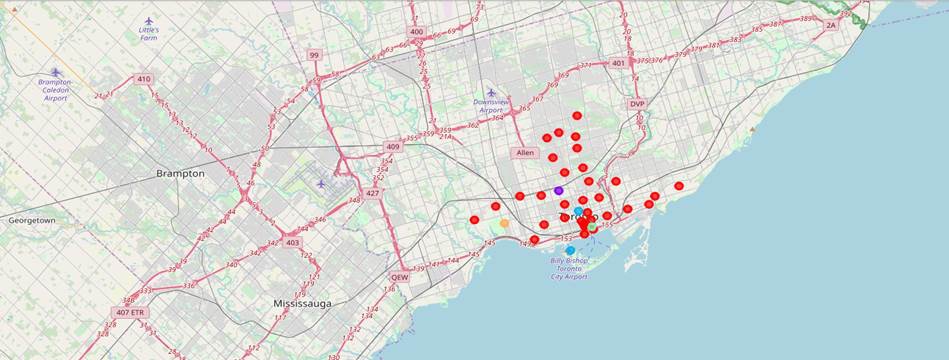

In [2]:
from IPython.display import Image
Image (filename='C:/Users/sudha27/Desktop/img/image004.png')

### STEP 6 - Examine Cluster

##### Cluster 1

In [75]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,-79.293031,0,Coffee Shop,Pub,Neighborhood,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
1,East Toronto,-79.352188,0,Greek Restaurant,Ice Cream Shop,Coffee Shop,Italian Restaurant,Bookstore,Bubble Tea Shop,Furniture / Home Store,Fruit & Vegetable Store,Juice Bar,Spa
2,East Toronto,-79.315572,0,Park,Sandwich Place,Gym,Ice Cream Shop,Burger Joint,Fast Food Restaurant,Pet Store,Fish & Chips Shop,Burrito Place,Liquor Store
3,East Toronto,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Sandwich Place
4,Central Toronto,-79.388790,0,Park,Lake,Dim Sum Restaurant,Swim School,Bus Line,Yoga Studio,Dumpling Restaurant,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
5,Central Toronto,-79.390197,0,Breakfast Spot,Food & Drink Shop,Park,Hotel,Sandwich Place,Burger Joint,Clothing Store,Yoga Studio,Ethiopian Restaurant,Dumpling Restaurant
6,Central Toronto,-79.405678,0,Clothing Store,Sporting Goods Shop,Coffee Shop,Yoga Studio,Fast Food Restaurant,Metro Station,Mexican Restaurant,Diner,Dessert Shop,Park
7,Central Toronto,-79.388790,0,Dessert Shop,Sandwich Place,Pizza Place,Seafood Restaurant,Café,Coffee Shop,Sushi Restaurant,Italian Restaurant,Deli / Bodega,Burger Joint
8,Central Toronto,-79.383160,0,Playground,Gym,Yoga Studio,Dog Run,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
9,Central Toronto,-79.400049,0,Coffee Shop,Pub,Convenience Store,Sushi Restaurant,Fried Chicken Joint,Supermarket,Sports Bar,American Restaurant,Light Rail Station,Vietnamese Restaurant


##### Cluster 2

In [76]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Downtown Toronto,-79.374846,1,Coffee Shop,Restaurant,Café,Italian Restaurant,Seafood Restaurant,Pub,Hotel,Cocktail Bar,Creperie,Bakery


##### Cluster 3

In [77]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Central Toronto,-79.405678,2,Coffee Shop,Café,Sandwich Place,Pizza Place,Park,Pharmacy,Cosmetics Shop,Liquor Store,Jewish Restaurant,French Restaurant


##### Cluster 4

In [78]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,West Toronto,-79.456325,3,Breakfast Spot,Gift Shop,Burger Joint,Bar,Movie Theater,Eastern European Restaurant,Restaurant,Italian Restaurant,Dog Run,Bookstore


##### Cluster 5

In [79]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Downtown Toronto,-79.38316,4,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Burger Joint,Men's Store,Café,Gastropub,Fast Food Restaurant
27,Downtown Toronto,-79.39442,4,Airport Lounge,Airport Service,Airport Terminal,Boutique,Sculpture Garden,Plane,Airport,Airport Food Court,Airport Gate,Harbor / Marina
